In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import agama
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from matplotlib import patches

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

In [3]:
'''Import DR3 data'''

hdu = fits.open(datapath+'rvs_data_feh2_parsn3.fits', memmap=True)
t = Table.read(hdu)

In [4]:
'''Transform and cut data'''

coords = coord.SkyCoord(ra=t['RA']*u.deg, dec=t['DEC']*u.deg, distance=t['DIST']*u.kpc, pm_ra_cosdec=t['PMRA']*u.mas/u.yr, pm_dec=t['PMDEC']*u.mas/u.yr, radial_velocity=t['VLOS']*u.km/u.s)

galcen_v_sun = np.array([11.1, 247.4, 7.25])*u.km/u.s#(12.9, 245.6, 7.78)

R_sun = 8.178

coords = coords.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic = np.array([coords.x.value, coords.y.value, coords.z.value, coords.v_x.value, coords.v_y.value, coords.v_z.value]).T

print(ic.shape)

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic = ic*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn = t['PARSN']
dist = t['DIST']
MH = t['MH']
logg = t['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn > parsn_min) * (dist < dist_max)

ic = ic[cut]
MH = MH[cut]
logg = logg[cut]
dist = dist[cut]

(24008015, 6)


In [5]:
'''Remove large variables'''
del hdu, t, coords, parsn, cut

In [6]:
'''Calculate data quantities'''

# bar_angle = 30 * np.pi/180

# phi_data = (np.arctan2(ic[:,1], ic[:,0]) - bar_angle + np.pi) % (2 * np.pi) - np.pi

# plt.hist(phi_data*180/np.pi, bins=100)
# plt.show()
# plt.close()

# r_data = np.linalg.norm(ic[:,0:3], axis=1)
R_data = np.linalg.norm(ic[:,0:2], axis=1)
phi_data_sun = np.arctan2(ic[:,1], ic[:,0])
z_data = ic[:,2]

R_hat = ic[:,0:3] * [1, 1, 0] / R_data[:,None]
vR_data = (ic[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_data = (ic[:,3:6] * phi_hat).sum(axis=1)
# vz_data = ic[:,5]

# r_hat = ic[:,0:3] / r_data[:,None]
# vr_data = (ic[:,3:6] * r_hat).sum(axis=1)

Lz_data = np.cross(ic[:,0:3], ic[:,3:6])[:,2]

# Remove large variables
del R_hat, phi_hat

In [7]:
# Choose default potential

pot_axi_Hunter = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
pot_axi = pot_axi_Hunter

pot_axi_Hunter_baryon = agama.Potential(agama_pot_path+'MWPotentialHunter24_baryon_axi.ini')
pot_axi_baryon = pot_axi_Hunter_baryon

In [ ]:
from scipy.optimize import fsolve

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    result = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer), full_output=True)

    if result[2] == 1:

        a_NFW = result[0][0]
        rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

        return rho_0, a_NFW

    else:
        return np.nan, np.nan


In [244]:
vcirc_sun = 220
M20 = 1.28

vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

# Calculate model NFW parameters
Menc_sun_dark = R_sun * vcirc_dark**2 / agama.G
M20_baryon = pot_axi_baryon.enclosedMass(20)
M20_dark = M20*1e11 - M20_baryon

print(calc_NFW_params(Menc_sun_dark, M20_dark))

(nan, nan)


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/4214691218.py:6: RuntimeWarning: invalid value encountered in log
  return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))


In [786]:
'''Functions to calculate OLR orbit in as a function of potential parameters and pattern speed'''
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
import time

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    result = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer), full_output=True)

    if result[2] == 1:

        a_NFW = result[0][0]
        rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

        return rho_0, a_NFW

    else:
        return np.nan, np.nan

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, M20, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # Calculate model NFW parameters
    Menc_sun_dark = R_sun * vcirc_dark**2 / agama.G
    M20_baryon = pot_axi_baryon.enclosedMass(20)
    M20_dark = M20*1e11 - M20_baryon
    
    rho_0, a_NFW = calc_NFW_params(Menc_sun_dark, M20_dark)

    if (np.isnan(rho_0) == False)*(np.isnan(a_NFW) == False):

        # Make DM potential
        pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

        # And total potential
        pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

        return pot_mod
    
    # Return error value of -1 if potential impossible
    else:
        return -1
        

# Function to calculate exact OLR orbit in given axisymmetric potential with given pattern speed and Lz
def calc_res_orbit(pot, Omega_b, res_ratio, Lz, m=0, c=0):

    # Make grid of initial conditions at Sun's radius
    if res_ratio == 0.5:
        # Optimized OLR grid (for MCMC)
        N_grid = 24
        vR_grid = np.linspace(200, 400, N_grid)
        R_ic = R_sun

    elif res_ratio == 0:
        # Optimized OLR grid (for MCMC)
        N_grid = 24
        vR_grid = np.linspace(100, 400, N_grid)
        R_ic = 5
    
    else:
        # Broad, fine grid for other resonances
        N_grid = 48
        vR_grid = np.linspace(0, 1000, N_grid)
        R_ic = 4
    
    ic = np.array([R_ic*np.ones(N_grid), np.zeros(N_grid), np.zeros(N_grid), vR_grid, Lz/R_ic*np.ones(N_grid), 1e-1*np.ones(N_grid)]).T

    # Integrate orbits
    o = agama.orbit(ic=ic, potential=pot, Omega=Omega_b, time=2*2*np.pi/Omega_b, trajsize=1001, verbose=False)
    ts = o[:,0][0]
    orbits = np.stack(o[:,1]).transpose((1,0,2))
    
    # Calculate cylindrical coordinates and locate apocentres
    R_orbits = np.linalg.norm(orbits[:,:,0:2], axis=-1)
    R_hat = orbits[:,:,0:3] * [1, 1, 0] / R_orbits[:,:,None]   
    vR_orbits = (orbits[:,:,3:6] * R_hat).sum(axis=-1)
    
    phi_orbits = np.arctan2(orbits[:,:,1], orbits[:,:,0]) + Omega_b * ts[:,None]
    phi_orbits_unwrap = np.unwrap(phi_orbits, axis=0)
    apo_indices = np.where((vR_orbits[:-1] > 0)*(vR_orbits[1:] < 0))

    # Calculate radial periods and frequencies
    T_R = np.full(vR_orbits.shape[1], np.nan)
    Omega_phi = np.full(vR_orbits.shape[1], np.nan)

    for i in range(vR_orbits.shape[1]):
        column_true_indices = apo_indices[0][apo_indices[1] == i]  # Get the indices of True values in column i
        if len(column_true_indices) >= 2:
            T_R[i] = (column_true_indices[1] - column_true_indices[0]) * (ts[1] - ts[0])
            Omega_phi[i] = (phi_orbits_unwrap[column_true_indices[1],i] - phi_orbits_unwrap[column_true_indices[0],i]) / (ts[column_true_indices[1]] - ts[column_true_indices[0]])
    
    Omega_R = 2*np.pi / T_R
    freq_ratio = -(Omega_phi - Omega_b)/Omega_R

    # Create fine grid in vR for interpolation
    vR_grid_fine = np.linspace(vR_grid[0], vR_grid[-1], 1001)
    freq_ratio_inter = np.interp(vR_grid_fine, vR_grid, freq_ratio)
    
    # Find ICs giving orbit closest to resonance
    res_dist = abs(freq_ratio_inter - res_ratio)

    res_index = np.nanargmin(res_dist)
    res_ic = ic[0]
    res_ic[3] = vR_grid_fine[res_index]

    # Integrate resonant orbit and calculate coordinates
    res_orbit = agama.orbit(ic=res_ic, potential=pot, Omega=Omega_b, time=2*np.pi/Omega_b, trajsize=1001)[1]

    # plt.plot(res_orbit[:,0], res_orbit[:,1])

    R_orbit = np.linalg.norm(res_orbit[:,0:2], axis=-1)
    R_hat = res_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
    vR_orbit = (res_orbit[:,3:6] * R_hat).sum(axis=-1)

    # Locate first apocentre and pericentre
    try:
        first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
        first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]
    
    # If apocentre or pericentre does not exist, re-integrate orbit for longer
    except:
        res_orbit = agama.orbit(ic=res_ic, potential=pot, Omega=Omega_b, time=4*np.pi/Omega_b, trajsize=1001)[1]
        R_orbit = np.linalg.norm(res_orbit[:,0:2], axis=-1)
        R_hat = res_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
        vR_orbit = (res_orbit[:,3:6] * R_hat).sum(axis=-1)

        first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
        first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]

    # Create cubic spline from orbit
    R_orbit_cut = R_orbit[first_apo_index+1:first_peri_index-1]
    vR_orbit_cut = vR_orbit[first_apo_index+1:first_peri_index-1]

    adjustment = m * np.flip(R_orbit_cut) + c

    vR_func = CubicSpline(np.flip(R_orbit_cut), np.flip(-abs(vR_orbit_cut)) + adjustment, extrapolate=False)

    return vR_func

# Function to calculate model OLR orbit as a function of radius
def calc_model_func(theta_res, pot_axi_baryon, res_ratio):
    vcirc_sun, M20, Omega_b, Lz, m, c, sigma_model = theta_res
    pot_mod = make_pot(vcirc_sun, M20, pot_axi_baryon)

    if pot_mod == -1:
        return -1

    vR_func = calc_res_orbit(pot_mod, Omega_b, res_ratio, Lz, m, c)
    return vR_func

# Function to calculate log likelihood for each resonance
def calc_log_likelihood_res(theta_res, x, y, yerr, pot_axi_baryon, res_ratio):

    vcirc_sun, M20, Omega_b, Lz, m, c, sigma_model = theta_res

    log_likelihood = 0

    model_func = calc_model_func(theta_res, pot_axi_baryon, res_ratio)

    if model_func == -1:
        return -np.inf

    # try:
    
    model = model_func(x)
    
    # If model gives nan, set equal to 0 to avoid discontinuities in the likelihood
    model = np.nan_to_num(model)

    log_likelihood += -0.5 * ((y - model)**2 / (yerr**2 + sigma_model**2) + np.log(2*np.pi*(yerr**2 + sigma_model**2))).sum()

    # print(log_likelihood)

    return log_likelihood

# Function to calculate total log likelihood (for both CR and OLR)
def calc_log_likelihood(theta, x_list, y_list, yerr_list, pot_axi_baryon):

    vcirc_sun, M20, Omega_b, Lz_CR, m_CR, c_CR, sigma_CR, Lz_OLR, m_OLR, c_OLR, sigma_OLR = theta

    x_CR = x_list[0]
    y_CR = y_list[0]
    yerr_CR = yerr_list[0]

    x_OLR = x_list[1]
    y_OLR = y_list[1]
    yerr_OLR = yerr_list[1]

    theta_CR = [vcirc_sun, M20, Omega_b, Lz_CR, m_CR, c_CR, sigma_CR]
    theta_OLR = [vcirc_sun, M20, Omega_b, Lz_OLR, m_OLR, c_OLR, sigma_OLR]

    ll_CR = calc_log_likelihood_res(theta_CR, x_CR, y_CR, yerr_CR, pot_axi_baryon, 0)
    ll_OLR = calc_log_likelihood_res(theta_OLR, x_OLR, y_OLR, yerr_OLR, pot_axi_baryon, 0.5)

    return ll_CR + ll_OLR



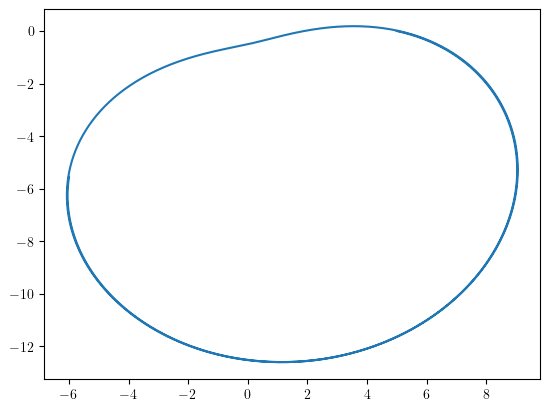

In [595]:
calc_res_orbit(pot_axi_sim, 25, 0, 250, m=0, c=0)

In [10]:
'''Load simulation to test'''

# Load pre-run simulation
o = np.load(simpath+'trajs_Hunter.npy', allow_pickle=True)

In [11]:
'''Calculate simulation quantities'''
from scipy.integrate import quad

# Functions to calculate pattern speed and bar angle
def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters (CAREFUL THAT THEY MATCH THE SIMULATION SETUP)
# Potential parameters
R_sun_sim = 8.178
vcirc_sun_sim = 229 #236.9

# Sun's position
phi_sun = -np.pi/6
X_sun = R_sun * np.cos(phi_sun)
Y_sun = R_sun * np.sin(phi_sun)

# Bar parameters
t0 = 0  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 60
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Calculate simulation coordinates
ts = o[:,0][0]
trajs = np.stack(o[:,1]).transpose((1,0,2))

# Delete original array to save memory
del o

# Calculate pattern speed and bar angle
Omega_b_sim = np.zeros(len(ts))
phi_b_sim = np.zeros(len(ts))

for i in range(len(ts)):
    Omega_b_sim[i] = calc_Omega_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b_sim[i] = calc_phi_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)

# Calculate cylindrical coordinates
R_sim = np.linalg.norm(trajs[:,:,0:2], axis=-1)
phi_sim = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] + np.pi)%(2*np.pi) - np.pi
phi_sim_sun = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] - phi_sun + np.pi/2)%(np.pi) - np.pi/2

R_hat = trajs[:,:,0:3] * [1, 1, 0] / R_sim[:,:,None]
phi_hat = np.cross([0,0,1], R_hat)
vR_sim = (trajs[:,:,3:6] * R_hat).sum(axis=-1)
vphi_sim = (trajs[:,:,3:6] * phi_hat).sum(axis=-1)

# Calculate coordinates in bar's frame
X_sim = R_sim * np.cos(phi_sim)
Y_sim = R_sim * np.sin(phi_sim)
z_sim = trajs[:,:,2]

# Angular momentum
Lz_sim = np.cross(trajs[:,:,0:3], trajs[:,:,3:6])[:,:,2]

# Distance from Sun
dist_sim = ((X_sim - X_sun)**2 + (Y_sim - Y_sun)**2 + z_sim**2)**0.5


In [12]:
# Potential and pattern speed in simulation
pot_axi_sim = pot_axi_Hunter
vcirc_sun_sim = (-R_sun * pot_axi_sim.force([R_sun, 0, 0])[0])**0.5
M20_sim = pot_axi_sim.enclosedMass(20)/1e11

print(vcirc_sun_sim)
print(M20_sim)

228.82908871423456
1.9332801965472497


In [13]:
'''Select fiducial simulation snapshot'''

snap = -2

Omega_b = Omega_b_sim[snap]

print('Fiducial pattern speed Omega_b =', Omega_b, 'km/s/kpc')

Fiducial pattern speed Omega_b = 32.50270916353844 km/s/kpc


<>:203: SyntaxWarning: invalid escape sequence '\O'
<>:203: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/3378412673.py:203: SyntaxWarning: invalid escape sequence '\O'
  axs[1].set_title('Simulation ($\Omega_\mathrm{b}=$ '+'{:.1f}'.format(Omega_b_sim[snap])+' km/s/kpc)', fontsize=16)


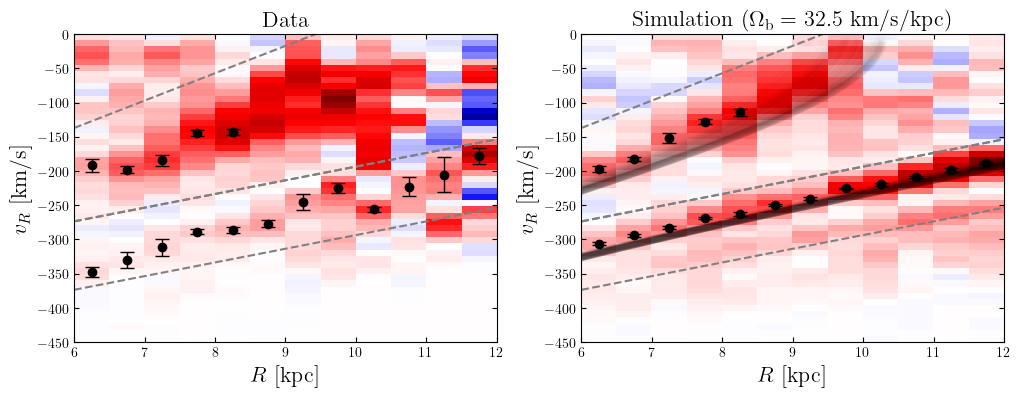

In [ ]:
'''Generate data from antisymmetric distribution as function of radius'''
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

vR_bins = np.linspace(-400, 400, 101)
vR_grid = np.linspace(-400, 400, 1001)
vR_bincentres = (vR_bins[1:] + vR_bins[:-1])/2
vphi_bins = np.linspace(0, 100, 11)

vR_binwidth = vR_bins[1] - vR_bins[0]

R_bins = np.linspace(6, 12, 13)
R_bincentres = (R_bins[1:] + R_bins[:-1])/2


# Function to calculate R-vR antisymmetric histogram
def R_vR_antisym(R, vR, R_bins, vR_bins):
    hist, _, _ = np.histogram2d(R, vR, bins=(R_bins, vR_bins))

    hist = gaussian_filter(hist, (0,1))

    vR_bincentres = 0.5*(vR_bins[1:]+vR_bins[:-1])
    vphi_bincentres = 0.5*(vphi_bins[1:]+vphi_bins[:-1])

    hist_colnorm = hist / hist.sum(axis=1)[:,None]

    hist_antisym = (hist_colnorm - np.flip(hist_colnorm, axis=1))#/(hist + np.flip(hist, axis=1))#hist - np.flip(hist, axis=1)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
    hist_antisym = np.nan_to_num(hist_antisym)
    # hist_antisym_smooth = gaussian_filter(hist_antisym, (0,1))

    return hist_antisym

# Function to calculate kde in each vR bin
def R_vR_antisym_kde(R, vR, R_bins, vR_grid, sigma_kde):
    kde_antisym = np.zeros((len(R_bins)-1, len(vR_grid)))
    for i in range(len(R_bins)-1):
        cut = (R > R_bins[i])*(R < R_bins[i+1])
        bw = sigma_kde / np.std(vR[cut])
        kde = gaussian_kde(vR[cut], bw_method=bw)
        kde_grid = kde(vR_grid)
        kde_antisym[i] = (kde_grid - np.flip(kde_grid))#/(kde_grid + np.flip(kde_grid))
    
    # kde_antisym_smooth = gaussian_filter(kde_antisym, (1, 0))

    return kde_antisym

# Function to calculate peaks and uncertainties from bootstrapping
def calc_R_vR_peaks(R, vR, R_bins, vR_grid, sigma_kde, n_bootstrap, res_bounds):

    # Array to store highest peaks
    peaks_array = np.zeros((len(R_bins)-1, n_bootstrap))

    # Loop over all R bins
    for i in range(len(R_bins)-1):
        cut = (R > R_bins[i])*(R < R_bins[i+1])
        data = vR[cut]

        # Bootstrap sample
        for j in range(n_bootstrap):
            bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
            # Fit kde and antisymmetrised kde
            bw = sigma_kde / np.std(bootstrap_sample)
            kde = gaussian_kde(bootstrap_sample, bw_method=bw)
            kde_grid = kde(vR_grid)
            kde_antisym = (kde_grid - np.flip(kde_grid))#/(kde_grid + np.flip(kde_grid))

            # Find peaks
            peak_indices, peak_props = find_peaks(kde_antisym, prominence=0., height=0.)#, distance=50/vR_gridspace)

            # Order peaks by their heights (or prominences)
            peak_prom = peak_props['prominences']
            peak_height = peak_props['peak_heights']
            peak_order = np.argsort(-peak_prom)

            # Select highest (or most prominent) peaks
            peak_indices = peak_indices[peak_order]#[:5]
            vR_peaks = vR_grid[peak_indices]

            # Find most prominent peaks within boundaries
            peaks = (vR_peaks < res_bounds[0](R_bincentres[i]))*(vR_peaks > res_bounds[1](R_bincentres[i]))*(vR_peaks < 0)

            try:
                peaks_array[i,j] = vR_peaks[peaks][0]

            except:
                peaks_array[i,j] = np.nan
    
    return peaks_array


def calc_datapoints(peaks):
    y = np.nanmedian(peaks, axis=-1)
    yerr = 0.5*(np.nanpercentile(peaks, 84, axis=-1) - np.nanpercentile(peaks, 16, axis=-1))
    return y, yerr


# Calculate histograms or KDEs for data and sim
# Select range around the Sun
phi_range = 1/12*np.pi
z_max = 2

# Kde width (in km/s) and number of bootstrap samples
sigma_kde = 10
n_bootstrap = 100

# Boundaries of region in which to search for OLR peaks
CR_bounds = [lambda R: 40*(R - R_sun) - 50, lambda R: 20*(R - R_sun) - 230]#, lambda R: 20*(R - 8) - 320]
OLR_bounds = [lambda R: 20*(R - R_sun) - 230, lambda R: 20*(R - R_sun) - 330]

# Bins for each resonance
bins_CR = R_bins[0:6]
bins_OLR = R_bins

# Simulation snapshot
snap = -2

# Data
cut_data = (Lz_data > 0)*(abs(Lz_data) < 500)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)
hist_antisym_data = R_vR_antisym(R_data[cut_data], vR_data[cut_data], R_bins, vR_bins)

peaks_CR_data = calc_R_vR_peaks(R_data[cut_data], vR_data[cut_data], bins_CR, vR_grid, sigma_kde, n_bootstrap, CR_bounds)

x_CR_data = 0.5*(bins_CR[1:] + bins_CR[:-1])
y_CR_data, yerr_CR_data = calc_datapoints(peaks_CR_data)

peaks_OLR_data = calc_R_vR_peaks(R_data[cut_data], vR_data[cut_data], bins_OLR, vR_grid, sigma_kde, n_bootstrap, OLR_bounds)

x_OLR_data = 0.5*(bins_OLR[1:] + bins_OLR[:-1])
y_OLR_data, yerr_OLR_data = calc_datapoints(peaks_OLR_data)

x_data_list = [x_CR_data, x_OLR_data]
y_data_list = [y_CR_data, y_OLR_data]
yerr_data_list = [yerr_CR_data, yerr_OLR_data]


# Simulation
cut_sim = (Lz_sim[snap] > 0)*(abs(Lz_sim[snap]) < 500)*(abs(phi_sim_sun[snap]) < phi_range)*(abs(z_sim[snap]) < z_max)#(phi_sim[snap]%np.pi > 2/3*np.pi)*(phi_sim[snap] < np.pi)
hist_antisym_sim = R_vR_antisym(R_sim[snap,cut_sim], vR_sim[snap,cut_sim], R_bins, vR_bins)

peaks_CR_sim = calc_R_vR_peaks(R_sim[snap,cut_sim], vR_sim[snap,cut_sim], bins_CR, vR_grid, sigma_kde, n_bootstrap, CR_bounds)

x_CR_sim = 0.5*(bins_CR[1:] + bins_CR[:-1])
y_CR_sim, yerr_CR_sim = calc_datapoints(peaks_CR_sim)

peaks_OLR_sim = calc_R_vR_peaks(R_sim[snap,cut_sim], vR_sim[snap,cut_sim], bins_OLR, vR_grid, sigma_kde, n_bootstrap, OLR_bounds)

x_OLR_sim = 0.5*(bins_OLR[1:] + bins_OLR[:-1])
y_OLR_sim, yerr_OLR_sim = calc_datapoints(peaks_OLR_sim)

x_sim_list = [x_CR_sim, x_OLR_sim]
y_sim_list = [y_CR_sim, y_OLR_sim]
yerr_sim_list = [yerr_CR_sim, yerr_OLR_sim]

# Plot antisymmetrised histograms
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(hist_antisym_data.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')
axs[1].imshow(hist_antisym_sim.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')

# Plot datapoints and errors
axs[0].errorbar(x_CR_data, y_CR_data, yerr_CR_data, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
axs[0].errorbar(x_OLR_data, y_OLR_data, yerr_OLR_data, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
axs[1].errorbar(x_CR_sim, y_CR_sim, yerr_CR_sim, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
axs[1].errorbar(x_OLR_sim, y_OLR_sim, yerr_OLR_sim, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

# Plot boundaries between resonant regions
for i in range(len(CR_bounds)):
    axs[0].plot(R_bins, CR_bounds[i](R_bins), ls='--', c='grey')
    axs[1].plot(R_bins, CR_bounds[i](R_bins), ls='--', c='grey')

for i in range(len(OLR_bounds)):
    axs[0].plot(R_bins, OLR_bounds[i](R_bins), ls='--', c='grey')
    axs[1].plot(R_bins, OLR_bounds[i](R_bins), ls='--', c='grey')

# # Plot peaks
# for i in range(len(R_bincentres)):
#     axs[0].scatter(R_bincentres[i]*np.ones(n_bootstrap), CR_peaks_data[i].flatten(), s=0.1, c='k')
#     axs[0].scatter(R_bincentres[i]*np.ones(n_bootstrap), OLR_peaks_data[i].flatten(), s=0.1, c='grey')

#     axs[1].scatter(R_bincentres[i]*np.ones(n_bootstrap), CR_peaks_sim[i].flatten(), s=0.1, c='k')
#     axs[1].scatter(R_bincentres[i]*np.ones(n_bootstrap), OLR_peaks_sim[i].flatten(), s=0.1, c='grey')
#     # axs[1].scatter(R_bincentres[i]*np.ones(), peaks_sim[i].flatten(), s=0.1, c='k')

# Calculate true resonant orbits for simulation
res_ratio_list = [0., 0.5]
Lz_grid = np.linspace(10, 500, 50)
R_grid = np.linspace(R_bins[0], R_bins[-1], 101)
 #make_pot(vcirc_sun_sim, a_NFW_sim, pot_axi_baryon)

for i in range(len(Lz_grid)):
    for j in range(len(res_ratio_list)):
        vR_res = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap], res_ratio_list[j], Lz_grid[i])
        axs[1].plot(R_grid, vR_res(R_grid), c='k', alpha=0.02, lw=5)


for ax in axs.flat:
    ax.set_ylim(top=0)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_xlabel('$R$ [kpc]', fontsize=16)
    ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

axs[0].set_title('Data', fontsize=16)
axs[1].set_title('Simulation ($\Omega_\mathrm{b}=$ '+'{:.1f}'.format(Omega_b_sim[snap])+' km/s/kpc)', fontsize=16)


# # Calculate a fiducial OLR orbit
# pot_axi_Hunter = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
# vR_func_list = calc_res_orbit(pot_axi_Hunter, Omega_b_sim[snap], res_ratio_list, 250)

# for j in range(len(res_ratio_list)):
#     vR_func = vR_func_list[j]
#     R_grid = np.linspace(R_bins[0], R_bins[-1], 1001)
#     ax.plot(R_grid, vR_func(R_grid), c='k')

plt.show()
plt.close()




-3
[108 165 229 302 350 405 429 483 544 619 793 997]
[ 22  76 128 183 321 450 518 591 751]
[ 14 103 141 200 356 395 471 565 720 959]
[ 30  57  85 155 214 377 419 482 704 886]
[ 12  66 174 225 406 492 523 688 894 957]
[ 53 127 173 237 326 438 713 923 980]
[  1  52 105 181 249 314 355 445 591 715 870 924]
[ 41 108 154 199 259 334 395 470 570 643 690]
[ 37 131 168 199 268 328 387 463 928 996]
[ 63 108 177 213 286 408 487 558 653 865 966]
[ 63 151 217 294 357 400 455 488 667 753 880]
[ 38  86 169 225 305 431 527 617 653 743 886 941]


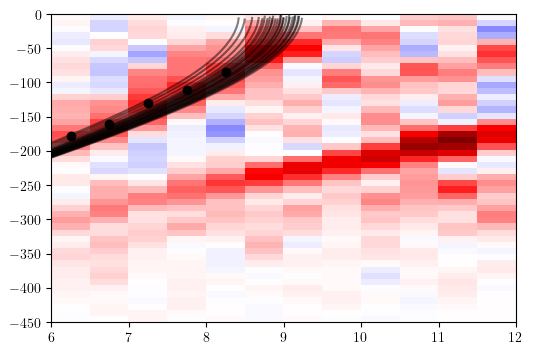

-2
[103 160 281 337 391 524 578 637 777 990]
[ 70 122 173 240 297 345 450 519 607 978]
[ 30  87 129 185 332 432 482 549 592 749 948]
[ 96 144 201 268 357 481 576 710 755 984]
[ 77 153 208 374 434 476 972]
[101 159 222 399 509 973]
[  9 108 172 233 317 420 487 868 954]
[ 13  63 122 149 181 249 315 373 419 471 968]
[148 188 256 314 388 471 506 555 954 995]
[ 86 197 268 355 394 464 568 893 950]
[ 49 136 168 207 280 351 418 492 536 626 898 928]
[ 51 168 216 291 376 405 448 487 659 927 973]


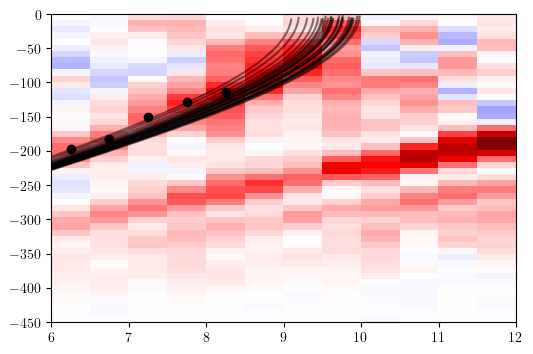

-1
[ 14  50 103 149 278 388 430 478 549 646 673 794]
[ 17  62 106 162 221 286 391 464 512 564 675]
[ 30 128 177 301 493 541 586 616 950 998]
[ 41 127 189 304 511 544 599 763]
[ 26 105 143 199 338 435 523 595 716 952]
[  6 151 210 371 546 567 691 724 957]
[ 52  91 155 224 397 532 709 991]
[136 167 237 341 434 517 692 949 989]
[ 61 144 183 245 337 411 450 711 923 985]
[ 48 141 189 256 421 483 672]
[ 29 118 154 202 262 327 373 411 477 556 939]
[ 24  78 149 203 276 353 438 512 616 686 772 955]


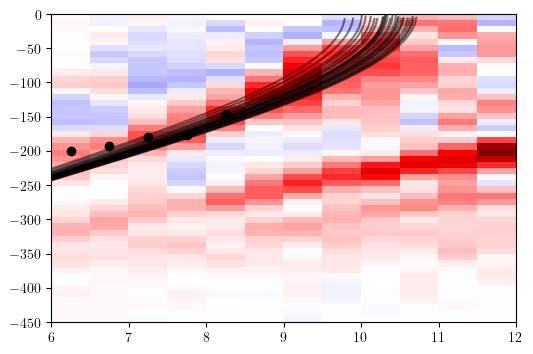

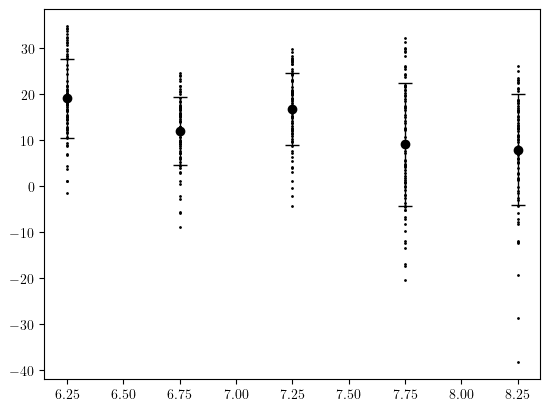

100%|██████████| 10000/10000 [00:02<00:00, 3356.19it/s]


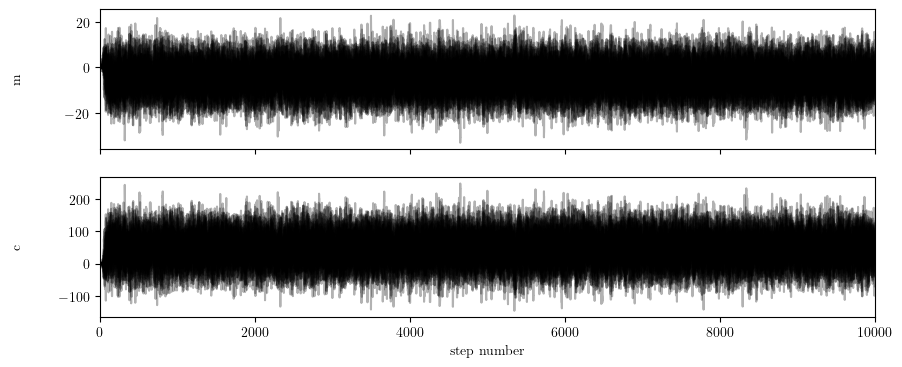

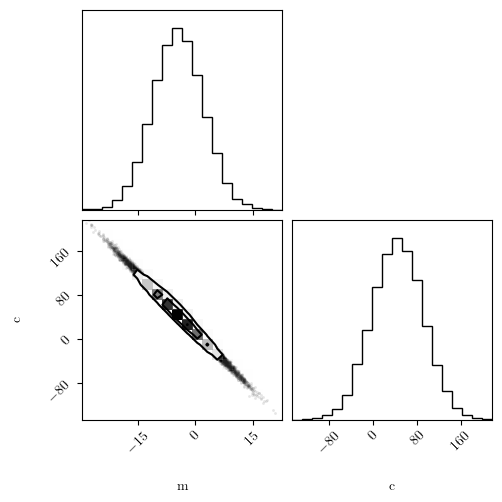

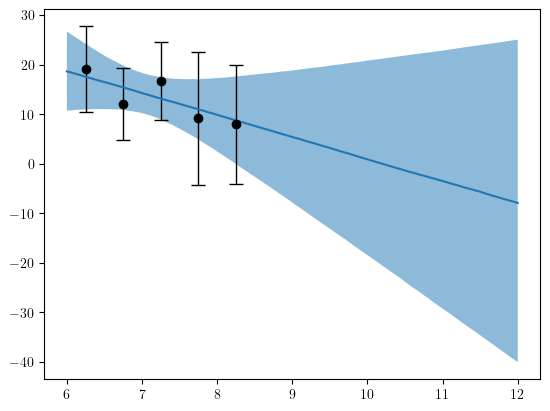

-3
[108 165 229 302 350 405 429 483 544 619 793 997]
[ 22  76 128 183 321 450 518 591 751]
[ 14 103 141 200 356 395 471 565 720 959]
[ 30  57  85 155 214 377 419 482 704 886]
[ 12  66 174 225 406 492 523 688 894 957]
[ 53 127 173 237 326 438 713 923 980]
[  1  52 105 181 249 314 355 445 591 715 870 924]
[ 41 108 154 199 259 334 395 470 570 643 690]
[ 37 131 168 199 268 328 387 463 928 996]
[ 63 108 177 213 286 408 487 558 653 865 966]
[ 63 151 217 294 357 400 455 488 667 753 880]
[ 38  86 169 225 305 431 527 617 653 743 886 941]


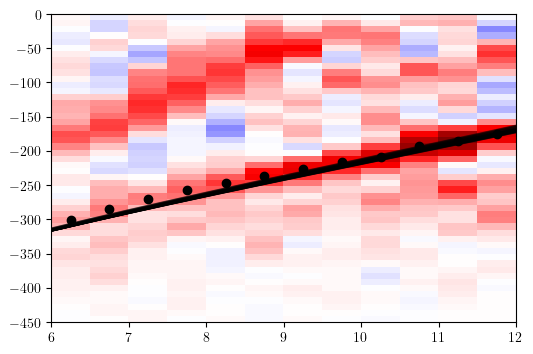

-2
[103 160 281 337 391 524 578 637 777 990]
[ 70 122 173 240 297 345 450 519 607 978]
[ 30  87 129 185 332 432 482 549 592 749 948]
[ 96 144 201 268 357 481 576 710 755 984]
[ 77 153 208 374 434 476 972]
[101 159 222 399 509 973]
[  9 108 172 233 317 420 487 868 954]
[ 13  63 122 149 181 249 315 373 419 471 968]
[148 188 256 314 388 471 506 555 954 995]
[ 86 197 268 355 394 464 568 893 950]
[ 49 136 168 207 280 351 418 492 536 626 898 928]
[ 51 168 216 291 376 405 448 487 659 927 973]


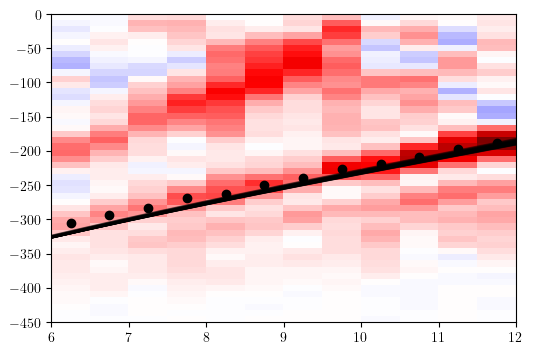

-1
[ 14  50 103 149 278 388 430 478 549 646 673 794]
[ 17  62 106 162 221 286 391 464 512 564 675]
[ 30 128 177 301 493 541 586 616 950 998]
[ 41 127 189 304 511 544 599 763]
[ 26 105 143 199 338 435 523 595 716 952]
[  6 151 210 371 546 567 691 724 957]
[ 52  91 155 224 397 532 709 991]
[136 167 237 341 434 517 692 949 989]
[ 61 144 183 245 337 411 450 711 923 985]
[ 48 141 189 256 421 483 672]
[ 29 118 154 202 262 327 373 411 477 556 939]
[ 24  78 149 203 276 353 438 512 616 686 772 955]


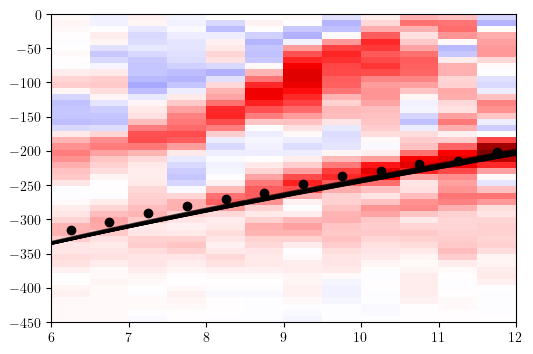

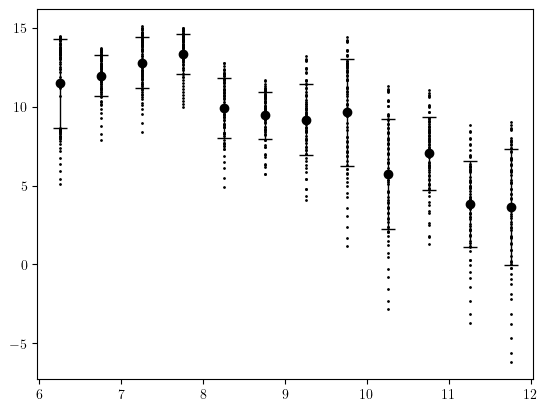

100%|██████████| 10000/10000 [00:02<00:00, 3354.71it/s]


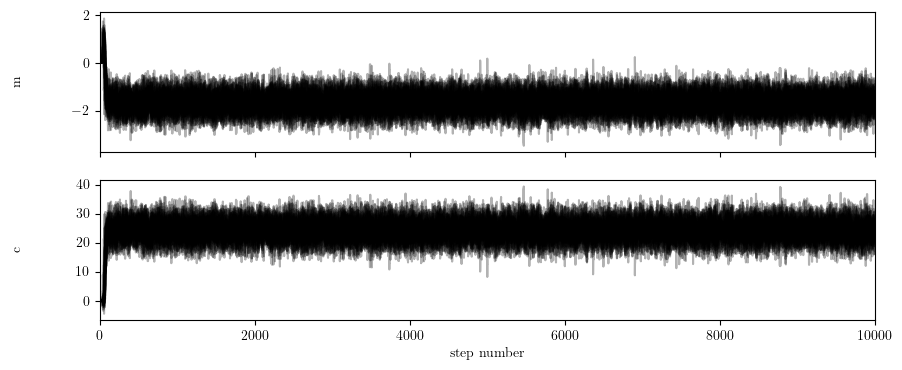

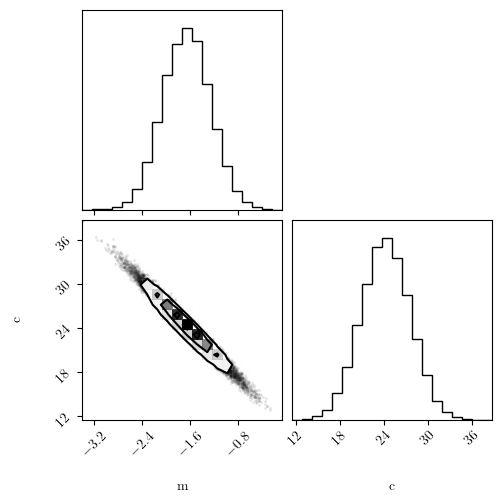

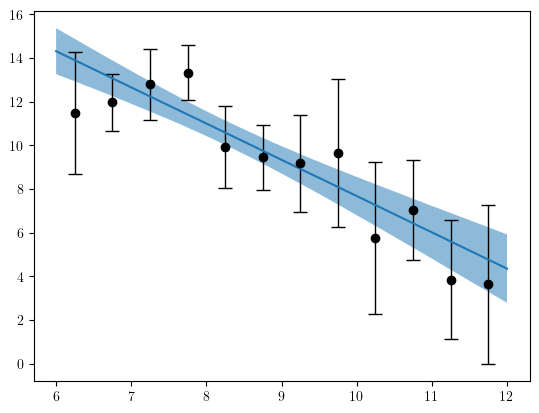

In [788]:
'''Calculate priors on offsets between resonances and peaks based on simulation'''

import emcee, corner

# Function to calculate closest peaks to resonances in simulation
def calc_R_vR_res_peak(R, vR, R_bins, vR_grid, sigma_kde, pot, Omega_b, res_ratio):

    # Calculate OLR orbit
    vR_res = calc_res_orbit(pot, Omega_b, res_ratio, 250, 0, 0)

    # Array to store highest peaks
    peaks_array = np.zeros(len(R_bins)-1)

    # Loop over all R bins
    for i in range(len(R_bins)-1):
        cut = (R > R_bins[i])*(R < R_bins[i+1])
        data = vR[cut]

        # Fit kde and antisymmetrised kde
        bw = sigma_kde / np.std(data)
        kde = gaussian_kde(data, bw_method=bw)
        kde_grid = kde(vR_grid)
        kde_antisym = (kde_grid - np.flip(kde_grid))#/(kde_grid + np.flip(kde_grid))

        # Find peaks
        peak_indices, peak_props = find_peaks(kde_antisym, prominence=0., height=0.)#, distance=50/vR_gridspace)

        print(peak_indices)

        # Order peaks by their heights (or prominences)
        peak_prom = peak_props['prominences']
        peak_height = peak_props['peak_heights']
        peak_order = np.argsort(-peak_prom)

        # Select highest (or most prominent) peaks
        peak_indices = peak_indices[peak_order][:6]
        vR_peaks = vR_grid[peak_indices]

        # Find peak closest to OLR
        R_bincentre = 0.5*(R_bins[i] + R_bins[i+1])
        peaks = np.argmin(abs(vR_peaks - vR_res(R_bincentre)))

        try:
            peaks_array[i] = vR_peaks[peaks]

        except:
            peaks_array[i] = np.nan
    
    return peaks_array


# Define the likelihood function
def log_likelihood_cal(theta, x, y, yerr):
    m, c = theta
    model_mean = m * x + c
    return -0.5 * np.sum((y - model_mean)**2 / yerr**2 + np.log(2 * np.pi * yerr**2))

# Define priors
def log_prior_cal(theta):
    m, c = theta
    if -200 < m < 200 and -2000 < c < 2000:  # Uniform priors
        return 0.0
    return -np.inf

# Define posterior
def log_probability_cal(theta, x, y, yerr):
    lp = log_prior_cal(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_cal(theta, x, y, yerr)

# Define function to calculate priors
def calc_m_c_priors(res_ratio, R_bins, vR_grid, sigma_kde, snap_cal_array, Lz_cal_array, N):

    R_bincentres = 0.5*(R_bins[:-1] + R_bins[1:])
    peaks_cal_diff_array = np.zeros((N, len(snap_cal_array), len(Lz_cal_array)))

    # Loop over different snapshots
    for i in range(len(snap_cal_array)):
        snap_cal = snap_cal_array[i]
        print(snap_cal)
        # Calculate simulation data points for calibration
        cut_cal = (Lz_sim[snap_cal] > 0)*(abs(Lz_sim[snap_cal]) < 500)*(abs(phi_sim_sun[snap_cal]) < phi_range)*(abs(z_sim[snap_cal]) < z_max)#(phi_sim[snap]%np.pi > 2/3*np.pi)*(phi_sim[snap] < np.pi)

        hist_antisym_cal = R_vR_antisym(R_sim[snap_cal,cut_cal], vR_sim[snap_cal,cut_cal], R_bins, vR_bins)
        peaks_cal = calc_R_vR_res_peak(R_sim[snap_cal,cut_cal], vR_sim[snap_cal,cut_cal], R_bins, vR_grid, sigma_kde, pot_axi_sim, Omega_b_sim[snap_cal], res_ratio)[:N]

        x_cal = R_bincentres[:N]

        # Plot histogram and peaks
        fig, ax = plt.subplots(figsize=(6,4))
        ax.imshow(hist_antisym_cal.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')
        ax.scatter(x_cal, peaks_cal, c='k')
        ax.set_ylim(vR_bins[0], 0)

        # Loop over grid of Lz and calculate exact resonant orbits
        for j in range(len(Lz_cal_array)):
            # Calculate true resonant orbits
            vR_res = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap_cal], res_ratio, Lz_cal_array[j], 0, 0)
            plt.plot(R_grid, vR_res(R_grid), c='k', alpha=0.5)

            # Calculate differences from data points
            peaks_cal_diff = peaks_cal - vR_res(x_cal)

            peaks_cal_diff_array[:,i,j] = peaks_cal_diff
        
        plt.show()
        plt.close()

    x_cal = R_bincentres[:N]
    y_cal = np.nanmean(peaks_cal_diff_array, axis=(-2,-1))
    yerr_cal = np.nanstd(peaks_cal_diff_array, axis=(-2,-1))

    for i in range(peaks_cal_diff_array.shape[1]):
        for j in range(peaks_cal_diff_array.shape[2]):
            plt.scatter(x_cal, peaks_cal_diff_array[:,i,j], s=1, c='k')


    plt.scatter(x_cal, y_cal, s=1, c='k')
    plt.errorbar(x_cal, y_cal, yerr_cal, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

    plt.show()
    plt.close()

    # Initialize walkers
    nwalkers, ndim = 32, 2
    pos = [0, 0] + 1e-4 * np.random.randn(nwalkers, ndim)

    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_cal, args=(x_cal, y_cal, yerr_cal))
    sampler.run_mcmc(pos, 10000, progress=True)

    fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
    samples = sampler.get_chain()
    labels = ['m', 'c']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")

    plt.show()
    plt.close()

    # Analyze the results
    samples = sampler.get_chain(discard=1000, thin=15, flat=True)

    # Corner plot
    fig = corner.corner(
        samples, labels=labels
    )
    plt.show()
    plt.close()

    # Fit and confidence interval
    plt.errorbar(x_cal, y_cal, yerr_cal, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

    fits = samples[:,0][None,:] * R_grid[:,None] + samples[:,1][None,:]

    plt.plot(R_grid, np.median(fits, axis=1))
    plt.fill_between(R_grid, np.percentile(fits, 16, axis=1), np.percentile(fits, 84, axis=1), alpha=0.5)
    
    plt.show()
    plt.close()

    # Calculate means and covariance matrix
    m_c_mean = np.mean(samples[:,:], axis=0)
    m_c_cov = np.cov(samples.T)

    return m_c_mean, m_c_cov


# Choose snapshots used for calibration
snap_cal_array = np.array([-3, -2, -1])
Lz_cal_array = np.linspace(5, 245, 25)

N_CR = len(bins_CR)-1
N_OLR = len(bins_OLR)-1

m_c_mean_CR, m_c_cov_CR = calc_m_c_priors(0, R_bins, vR_grid, sigma_kde, snap_cal_array, Lz_cal_array, N_CR)
m_c_mean_OLR, m_c_cov_OLR = calc_m_c_priors(0.5, R_bins, vR_grid, sigma_kde, snap_cal_array, Lz_cal_array, N_OLR)



In [777]:
'''TEST: double offest priors to check sensitivity'''

m_c_mean_CR = 2*m_c_mean_CR
m_c_mean_OLR = 2*m_c_mean_OLR

In [807]:
'''Define functions to calculate log prior and log probability'''

vcirc_sun_mean = 229 #236.9
vcirc_sun_std = 6 #4.2

# M20_mean = 1.91
# M20_std = 0.18

# Log prior
def calc_log_prior(theta):
    vcirc_sun, M20, Omega_b, Lz_CR, m_CR, c_CR, sigma_CR, Lz_OLR, m_OLR, c_OLR, sigma_OLR  = theta

    # Prior is uniform in pattern speed and NFW scale radius, and Gaussian in circular speed and energy offsets
    if (20 < Omega_b < 50) & (1 < M20 < 4) & (0 < Lz_CR < 500) & (0 < Lz_OLR < 500) & (0 < vcirc_sun < 500) & (0 < sigma_CR < 100) & (0 < sigma_OLR < 100):
        
        inv_m_c_cov_CR = np.linalg.inv(m_c_cov_CR)
        diff_m_c_CR = np.array([m_CR, c_CR]) - m_c_mean_CR

        inv_m_c_cov_OLR = np.linalg.inv(m_c_cov_OLR)
        diff_m_c_OLR = np.array([m_OLR, c_OLR]) - m_c_mean_OLR

        return -0.5 * (diff_m_c_CR.T @ inv_m_c_cov_CR @ diff_m_c_CR + diff_m_c_OLR.T @ inv_m_c_cov_OLR @ diff_m_c_OLR + (vcirc_sun - vcirc_sun_mean)**2 / vcirc_sun_std**2)#+ (M20 - M20_mean)**2 / M20_std**2)
    
    else:
        return -np.inf

def calc_log_probability(theta, x_list, y_list, yerr_list, pot_axi_baryon):
    lp = calc_log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf

    return lp + calc_log_likelihood(theta, x_list, y_list, yerr_list, pot_axi_baryon)

In [808]:
'''Find maximum likelihood or posterior'''
from scipy.optimize import minimize

nll = lambda *args: -calc_log_likelihood(*args)

initial = [230, 2, 35, 250, 0, 0, 10, 250, 0, 0, 10]
# initial = [235, 19.6, 35, 250, E_offset_mean, 10]

# Select data or simulation to fit
x = x_data_list #x_OLR_sim
y = y_data_list
yerr = yerr_data_list
# res_ratio = 0.5

# nlp(initial, x, y, yerr, pot_axi_baryon, res_ratio)

soln = minimize(nll, initial, args=(x, y, yerr, pot_axi_baryon), method='Nelder-Mead')

/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/3023021917.py:9: RuntimeWarning: invalid value encountered in log
  return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))


Maximum likelihood value: [ 2.59547739e+02  2.18930537e+00  4.04249246e+01  4.50312993e+02
 -2.05148191e-03  9.75937926e-04  7.45206699e+00  1.94770215e+02
 -2.17832375e-04  7.12588841e-04  4.78872436e+00]


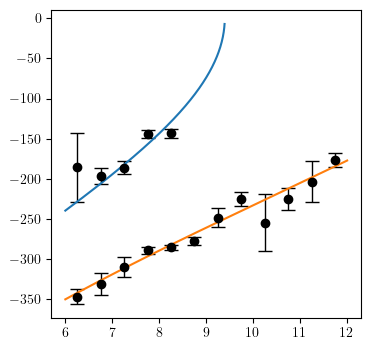

In [809]:
'''Plot data and maximum likelihood model'''

fig, ax = plt.subplots(1, figsize=(4,4))

# '''Maximum likelihood model'''
# max_likelihood_index = np.unravel_index(log_likelihood_array.argmax(), log_likelihood_array.shape)

# print(np.max(log_likelihood_array))

theta_max = soln.x#[vcirc_sun, a_NFW_grid[max_likelihood_index[1]], Omega_b_grid[max_likelihood_index[0]]]

vcirc_sun, M20, Omega_b, Lz_CR, m_CR, c_CR, sigma_CR, Lz_OLR, m_OLR, c_OLR, sigma_OLR  = theta_max

theta_CR = [vcirc_sun, M20, Omega_b, Lz_CR, m_CR, c_CR, sigma_CR]
theta_OLR = [vcirc_sun, M20, Omega_b, Lz_OLR, m_OLR, c_OLR, sigma_OLR]

print('Maximum likelihood value:', theta_max)

R_grid = np.linspace(R_bins[0], R_bins[-1], 1001)

vR_func_CR = calc_model_func(theta_CR, pot_axi_baryon, 0)
vR_func_OLR = calc_model_func(theta_OLR, pot_axi_baryon, 0.5)

for i in range(len(x)):
    ax.errorbar(x[i], y[i], yerr[i], c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

ax.plot(R_grid, vR_func_CR(R_grid))
ax.plot(R_grid, vR_func_OLR(R_grid))


In [810]:
'''Run MCMC'''

import emcee

# theta_true = [vcirc_sun_sim, a_NFW_sim, Omega_b_sim[snap], E_offset_mean]
pos = soln.x + 1e-4 * np.random.randn(32, len(soln.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, calc_log_probability, args=(x, y, yerr, pot_axi_baryon)
)
sampler.run_mcmc(pos, 2000, progress=True)

  1%|▏         | 25/2000 [00:07<09:21,  3.52it/s]/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/3023021917.py:9: RuntimeWarning: invalid value encountered in log
  return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
100%|██████████| 2000/2000 [07:31<00:00,  4.42it/s]


State([[ 2.25178494e+02  2.00148488e+00  2.94482131e+01  4.53849760e+02
  -3.99850638e+00  4.64182666e+01  1.06105878e+01  6.29426804e+01
  -1.31529549e+00  2.17978538e+01  1.96897521e+01]
 [ 2.24170655e+02  2.00593417e+00  2.95291050e+01  7.89107586e+00
  -5.48002408e+00  4.89178555e+01  2.46130462e+01  2.69209037e+02
  -1.38383606e+00  2.13985233e+01  1.38636923e+01]
 [ 2.25898593e+02  2.23981249e+00  3.12396044e+01  2.30766303e+02
  -1.54772987e+00  2.66190686e+01  4.92353348e+00  2.60726638e+02
  -1.50550494e+00  2.28061544e+01  1.05802183e+01]
 [ 2.34792742e+02  2.53813244e+00  3.62783874e+01  4.30008484e+02
  -6.27670019e+00  5.66131277e+01  5.49885812e+01  9.47502624e+01
  -1.66058166e+00  2.41238556e+01  1.62791415e+01]
 [ 2.37806902e+02  1.86967514e+00  3.30595669e+01  4.28446486e+02
   8.80500470e+00 -4.51390256e+01  7.92272533e+00  3.56399709e+02
  -2.15955367e+00  2.83877999e+01  2.37962496e+01]
 [ 2.29471139e+02  2.35029433e+00  3.28284676e+01  3.05851898e+02
  -1.99944625

Text(0.5, 0, 'step number')

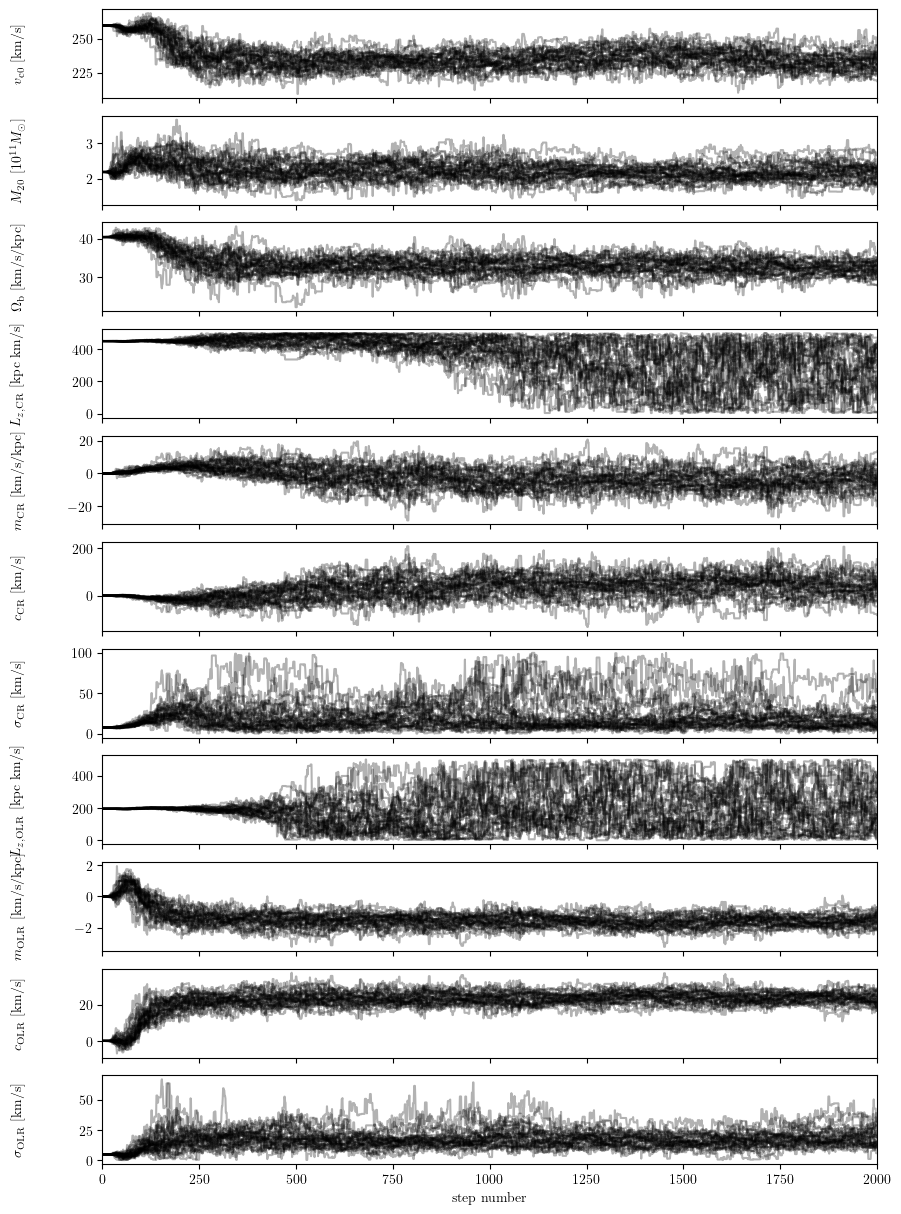

In [811]:
'''Display MCMC chains'''

fig, axes = plt.subplots(11, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
labels = ['$v_\\mathrm{c0}$ [km/s]', '$M_{20}$ [$10^{11}M_\\odot$]', '$\\Omega_\\mathrm{b}$ [km/s/kpc]', '$L_{z,\\mathrm{CR}}$ [kpc km/s]', '$m_\\mathrm{CR}$ [km/s/kpc]', '$c_\\mathrm{CR}$ [km/s]', '$\\sigma_\\mathrm{CR}$ [km/s]', '$L_{z,\\mathrm{OLR}}$ [kpc km/s]', '$m_\\mathrm{OLR}$ [km/s/kpc]', '$c_\\mathrm{OLR}$ [km/s]', '$\\sigma_\\mathrm{OLR}$ [km/s]']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [812]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [116.27304277 140.79894288 151.88564552 219.3846943  158.70152634
 163.83286366 111.80738977 112.28313085 144.17202995 145.39959908
  97.49246668]

[228.82908871423456, 1.9332801965472497, 35.25264359274281, 250, -4.393407493198826, 45.02388939038951, 0, 250, -1.660039244579075, 24.281058781423564, 0]


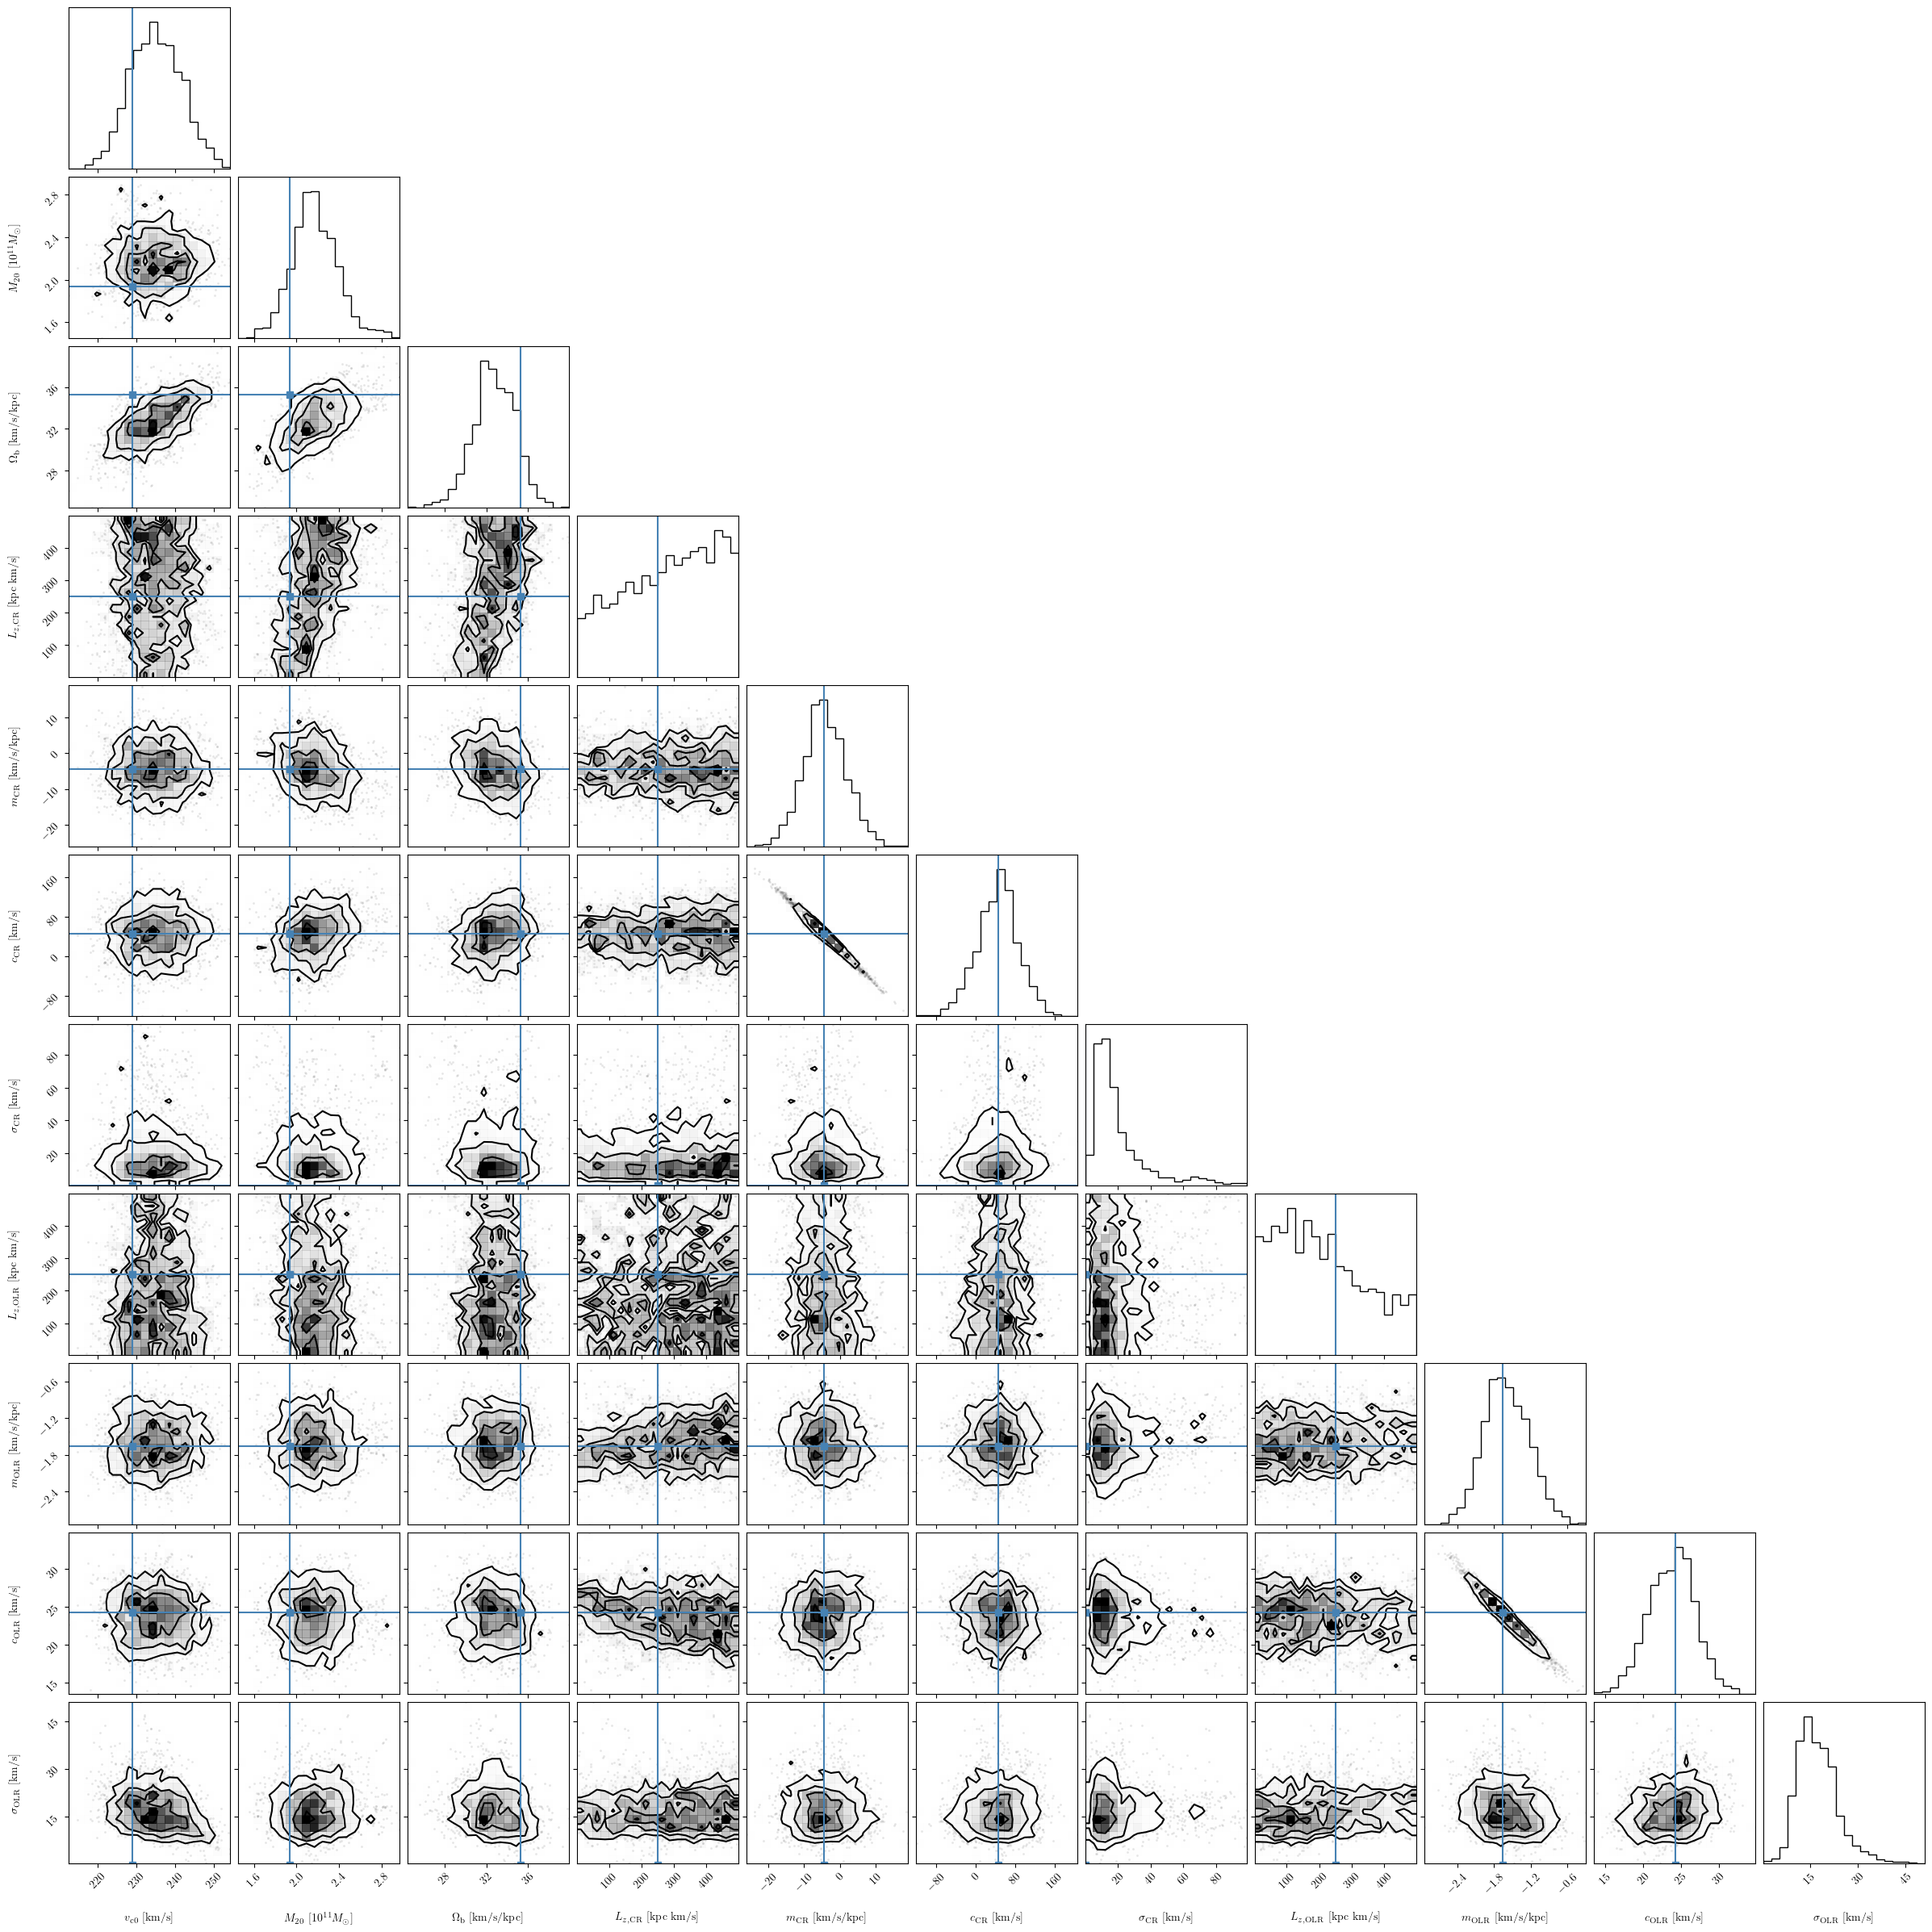

In [813]:
'''Display corner plot'''

import corner

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

theta_true = [vcirc_sun_sim, M20_sim, Omega_b_sim[snap], 250, m_c_mean_CR[0], m_c_mean_CR[1], 0, 250, m_c_mean_OLR[0], m_c_mean_OLR[1], 0]

print(theta_true)

labels = ['$v_\\mathrm{c0}$ [km/s]', '$M_{20}$ [$10^{11}M_\\odot$]', '$\\Omega_\\mathrm{b}$ [km/s/kpc]', '$L_{z,\\mathrm{CR}}$ [kpc km/s]', '$m_\\mathrm{CR}$ [km/s/kpc]', '$c_\\mathrm{CR}$ [km/s]', '$\\sigma_\\mathrm{CR}$ [km/s]', '$L_{z,\\mathrm{OLR}}$ [kpc km/s]', '$m_\\mathrm{OLR}$ [km/s/kpc]', '$c_\\mathrm{OLR}$ [km/s]', '$\\sigma_\\mathrm{OLR}$ [km/s]']
fig = corner.corner(
    flat_samples, labels=labels, truths=theta_true
)

In [819]:
'''Display parameter posteriors and confidence intervals'''

from IPython.display import display, Math

labels = ['v_\\mathrm{c0}', 'M_{20}', '\\Omega_\\mathrm{b}', 'L_{z,\\mathrm{CR}}', 'm_\\mathrm{CR}', 'c_\\mathrm{CR}', '\\sigma_\\mathrm{CR}', 'L_{z,\\mathrm{OLR}}', 'm_\\mathrm{OLR}', 'c_\\mathrm{OLR}', '\\sigma_\\mathrm{OLR}']
units = ['\\mathrm{km/s}', '10^{11}M_\\odot', '\\mathrm{km/s/kpc}', '\\mathrm{kpc\\,km/s}', '\\mathrm{km/s/kpc}', '\\mathrm{km/s}', '\\mathrm{km/s}', '\\mathrm{kpc\\,km/s}', '\\mathrm{km/s/kpc}', '\\mathrm{km/s}', '\\mathrm{km/s}']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3}_{{-{1:.2}}}^{{+{2:.2}}}\\:{{{4}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i], units[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<>:96: SyntaxWarning: invalid escape sequence '\o'
<>:98: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\o'
<>:98: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/4196264265.py:96: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_ylabel('$M(<r)$ [$10^{11} M_\odot$]', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/4196264265.py:98: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_ylabel('$v_\mathrm{circ}(r)$ [km/s]', fontsize=16)


Text(0, 0.5, '$v_\\mathrm{circ}(r)$ [km/s]')

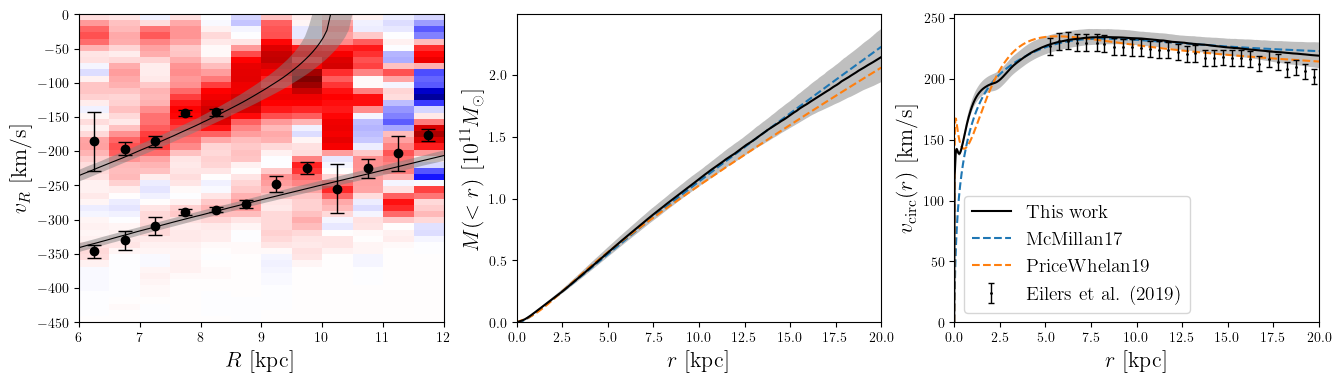

In [817]:
'''Plot best-fitting models'''

# Grids for plotting radial phase space and mass enclosed
R_grid = np.linspace(6, 12, 101)
r_grid = np.linspace(0, 20, 1001)

res_ratio = 0.5

fig, axs = plt.subplots(1, 3, figsize=(16,4))

N_samples = 500
rand_indices = np.random.randint(0, len(flat_samples), N_samples)
Menc_array = np.zeros((N_samples, len(r_grid)))
vcirc_array = np.zeros((N_samples, len(r_grid)))
vR_CR_array = np.zeros((N_samples, len(R_grid)))
vR_OLR_array = np.zeros((N_samples, len(R_grid)))

for i in range(N_samples):
    j = rand_indices[i]
    # print(flat_samples[i,0])
    pot_mod = make_pot(flat_samples[j,0], flat_samples[j,1], pot_axi_baryon)

    vR_CR = calc_res_orbit(pot_mod, flat_samples[j,2], 0, flat_samples[j,3])#, flat_samples[j,4], flat_samples[j,5])
    vR_CR_array[i] = np.nan_to_num(vR_CR(R_grid))

    vR_OLR = calc_res_orbit(pot_mod, flat_samples[j,2], 0.5, flat_samples[j,3])#, flat_samples[j,7], flat_samples[j,8])
    vR_OLR_array[i] = np.nan_to_num(vR_OLR(R_grid))

    Menc = pot_mod.enclosedMass(r_grid)/1e11
    Menc_array[i] = Menc

    vcirc = (-r_grid * pot_mod.force(np.array([r_grid, 0*r_grid, 0*r_grid]).T)[:,0])**0.5
    vcirc_array[i] = vcirc

# Plot radial phase space
axs[0].imshow(hist_antisym_data.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')

for i in range(len(x)):
    axs[0].errorbar(x[i], y[i], yerr[i], c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

axs[0].plot(R_grid, np.nanmedian(vR_CR_array, axis=0), c='k', lw=0.8, zorder=5)
axs[0].fill_between(R_grid, np.nanpercentile(vR_CR_array, 16, axis=0), np.nanpercentile(vR_CR_array, 84, axis=0), fc='grey', alpha=0.5)

axs[0].plot(R_grid, np.nanmedian(vR_OLR_array, axis=0), c='k', lw=0.8, zorder=5)
axs[0].fill_between(R_grid, np.nanpercentile(vR_OLR_array, 16, axis=0), np.nanpercentile(vR_OLR_array, 84, axis=0), fc='grey', alpha=0.5)

axs[1].plot(r_grid, np.nanmedian(Menc_array, axis=0), c='k', zorder=5)
axs[1].fill_between(r_grid, np.nanpercentile(Menc_array, 16, axis=0), np.nanpercentile(Menc_array, 84, axis=0), fc='grey', alpha=0.5)

axs[2].plot(r_grid, np.nanmedian(vcirc_array, axis=0), c='k', label='This work', zorder=5)
axs[2].fill_between(r_grid, np.nanpercentile(vcirc_array, 16, axis=0), np.nanpercentile(vcirc_array, 84, axis=0), fc='grey', alpha=0.5)


# # Plot other MW models for comparison
pot_mcmillan = agama.Potential(agama_pot_path+'McMillan17.ini')
Menc_mcmillan = pot_mcmillan.enclosedMass(r_grid)/1e11
vcirc_mcmillan = (-r_grid * pot_mcmillan.force(np.array([r_grid, 0*r_grid, 0*r_grid]).T)[:,0])**0.5

pot_pw = agama.Potential(agama_pot_path+'PriceWhelan19.ini')
Menc_pw = pot_pw.enclosedMass(r_grid)/1e11
vcirc_pw = (-r_grid * pot_pw.force(np.array([r_grid, 0*r_grid, 0*r_grid]).T)[:,0])**0.5

# Load Eilers+2019 rotation curve data
eilers_data = np.loadtxt(datapath+'eilers2019_rotcurve.txt', skiprows=1)

axs[1].plot(r_grid, Menc_mcmillan, ls='--')
axs[2].plot(r_grid, vcirc_mcmillan, label='McMillan17', ls='--')
axs[1].plot(r_grid, Menc_pw, ls='--')
axs[2].plot(r_grid, vcirc_pw, label='PriceWhelan19', ls='--')
axs[2].errorbar(eilers_data[:,0], eilers_data[:,1], 0.03*eilers_data[:,1], c='k', fmt='o', capsize=2, elinewidth=1, capthick=1, markersize=1, label='Eilers et al. (2019)')

# Plot true values in simulation (if applicable)
vR_CR_sim = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap], 0, 250, 0, 0)(R_grid)
vR_OLR_sim = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap], 0.5, 250, 0, 0)(R_grid)
Menc_sim = pot_axi_sim.enclosedMass(r_grid)/1e11
vcirc_sim = (-r_grid * pot_axi_sim.force(np.array([r_grid, 0*r_grid, 0*r_grid]).T)[:,0])**0.5

# axs[0].plot(R_grid, vR_CR_sim, c='tab:blue', lw=0.8)
# axs[0].plot(R_grid, vR_OLR_sim, c='tab:blue', lw=0.8)
# axs[1].plot(r_grid, Menc_sim, c='tab:blue')
# axs[2].plot(r_grid, vcirc_sim, c='tab:blue')


axs[2].legend(fontsize=14)

axs[0].set_ylim(vR_bins[0],0)
axs[1].set_xlim(0,20)
axs[1].set_ylim(0)
axs[2].set_xlim(0,20)
axs[2].set_ylim(0)

axs[0].set_xlabel('$R$ [kpc]', fontsize=16)
axs[0].set_ylabel('$v_R$ [km/s]', fontsize=16)

axs[1].set_xlabel('$r$ [kpc]', fontsize=16)
axs[1].set_ylabel('$M(<r)$ [$10^{11} M_\odot$]', fontsize=16)
axs[2].set_xlabel('$r$ [kpc]', fontsize=16)
axs[2].set_ylabel('$v_\mathrm{circ}(r)$ [km/s]', fontsize=16)


# print(calc_log_probability(np.median(flat_samples, axis=0), x, y, yerr, pot_axi_baryon, res_ratio))


# theta_true = [vcirc_sun_sim, M20_sim, Omega_b_sim[snap], 250, Delta_E_OLR_mean, 0]

# print(calc_log_probability(theta_true, x, y, yerr, pot_axi_baryon, res_ratio))




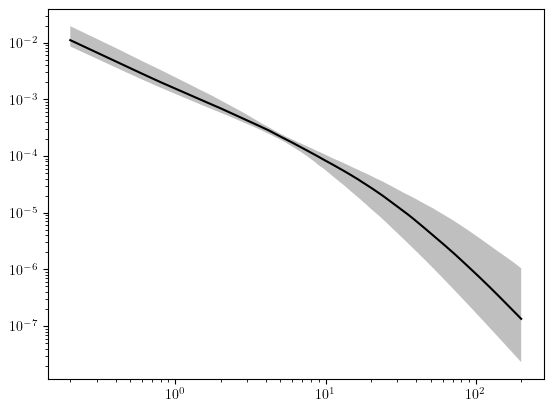

In [523]:
rho = (Menc_array[:,1:] - Menc_array[:,:-1]) / (4/3*np.pi * (r_grid[1:]**3 - r_grid[:-1]**3))

# plt.plot(r_grid[1:], rho[0], c='k')

plt.plot(r_grid[1:], np.nanmedian(rho, axis=0), c='k')
plt.fill_between(r_grid[1:], np.nanpercentile(rho, 16, axis=0), np.nanpercentile(rho, 84, axis=0), fc='grey', alpha=0.5)

plt.xscale('log')
plt.yscale('log')
